In [1]:
from onetwogo import Params
from onetwogo.parallel_simulation import ParallelSimulation
from onetwogo.experiment_simulation import ExperimentSimulation
from onetwogo.plot import SimulationPlot
from onetwogo.plot import BehavioralPlot

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
PARAMS_DICT = {'Wui': 6,
              'Wuv': 6,
              'Wvi': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'th': 0.65,
              'IF': 50,
              'uinit': 0.7,
              'vinit': 0.2,
              'yinit': 0.5,
               'Iinit': 0.8,
              'first_duration': 750, 
              'sigma': 0.01, 
              'ntrials': 500,
              'delay': 500}

# Functions

In [4]:
def load_data(short_path, long_path):
    short_data = []
    long_data = []
    with open(short_path, 'rb') as short:
        with open(long_path, 'rb') as long:
            try:
                while True:
                    short_data.append(pickle.load(short))
                    long_data.append(pickle.load(long))
            except EOFError:
                pass
    return short_data, long_data

In [5]:
# p = K, th, tau, delay
def to_matrix(result_lst, p1, p2, result):
    matrix = np.zeros((p1,p2))
    for i in range(len(result_lst)):
        matrix.flat[i] = result_lst[i][result]
    return matrix

In [6]:
def create_parameter_plot(short, long, shortlong, p1, p1_lst, p2, p2_lst, cmap, n_colors=20, norm=False):
    cmap = sns.color_palette(cmap, n_colors=n_colors)
    minmin = np.min([np.nanmin(short), np.nanmin(long), np.nanmin(shortlong)])
    maxmax = np.max([np.nanmax(short), np.nanmax(long), np.nanmax(shortlong)])
    print(minmin, maxmax)
    
    fig, ax = plt.subplots(1,3, figsize= (15,4), sharex=True, sharey=True)
    if norm == 'log':
        norm = matplotlib.colors.LogNorm(vmin=minmin, vmax=maxmax)
        
    if not norm:
        h1 = sns.heatmap(short, xticklabels=p2_lst, yticklabels=p1_lst, ax=ax[0], cmap = cmap, cbar=True)#,  vmin=minmin, vmax=maxmax)
        h2 = sns.heatmap(long, xticklabels=p2_lst, yticklabels=p1_lst, ax=ax[1], cmap = cmap, cbar=True)#,  vmin=minmin, vmax=maxmax)
        h3 = sns.heatmap(shortlong, xticklabels=p2_lst, yticklabels=p1_lst, ax=ax[2],  cmap = cmap)#, vmin=minmin, vmax=maxmax) #cbar_ax= cbar_ax,
    else:
        cbar_ax = fig.add_axes([.91, .25, .01, .5]) #x, y, breite, höhe
        h1 = sns.heatmap(short, xticklabels=p2_lst, yticklabels=p1_lst, ax=ax[0], cmap = cmap, cbar=False,  vmin=minmin, vmax=maxmax, norm=norm)
        h2 = sns.heatmap(long, xticklabels=p2_lst, yticklabels=p1_lst, ax=ax[1], cmap = cmap, cbar=False,  vmin=minmin, vmax=maxmax, norm=norm)
        h3 = sns.heatmap(shortlong, xticklabels=p2_lst, yticklabels=p1_lst, ax=ax[2],  cmap = cmap, cbar_ax= cbar_ax, vmin=minmin, vmax=maxmax, norm=norm)

    h1.set_xlabel(p2)
    h1.set_ylabel(p1)
    h1.set_title('short')

    h2.set_xlabel(p2)
    h2.set_title('long')

    h3.set_xlabel(p2)
    h3.set_title('short~long')
    
    plt.show()

In [73]:
def get_mse(data):
    bias2 = to_matrix(data, len(K_lst), len(tau), 'bias2')
    var = to_matrix(data, len(K_lst), len(tau), 'var')
    return bias2+var

In [74]:
def plot_slope(short, long, n_colors=20):
    short_ktau_slope = to_matrix(short, len(K_lst), len(tau), 'slope')
    long_ktau_slope = to_matrix(long, len(K_lst), len(tau), 'slope')
    divnorm=matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-1.2, vmax=1.2)
    create_parameter_plot(short_ktau_slope, long_ktau_slope, short_ktau_slope-long_ktau_slope, 'K', K_lst, 'tau', tau, 'coolwarm', n_colors=n_colors, norm=divnorm)
    plt.show()
    
def plot_mse(short, long, full=True):
    if full:
        error_short = get_mse(short)
        error_long = get_mse(long)
    if full=='bias':
        error_short = to_matrix(short, len(K_lst), len(tau), 'bias2')
        error_long = to_matrix(long, len(K_lst), len(tau), 'bias2')
    if full=='var':
        error_short = to_matrix(short, len(K_lst), len(tau), 'var')
        error_long = to_matrix(long, len(K_lst), len(tau), 'var')
    create_parameter_plot(error_short, error_long, (error_short+error_long)/2, 'K', K_lst, 'tau', tau, 'gray', n_colors=50, norm = 'log')
    plt.show()

def plot_mse_total(short, long):
    short_ktau_mse = to_matrix(short, len(K_lst), len(tau), 'MSE')
    long_ktau_mse = to_matrix(long, len(K_lst), len(tau), 'MSE')
    create_parameter_plot(short_ktau_mse, long_ktau_mse, (short_ktau_mse+long_ktau_mse)/2, 'K', K_lst, 'tau', tau, 'gray', n_colors=50)
    plt.show()
    
def plot_ind_point(short, long):
    short_ktau_indp = to_matrix(short, len(K_lst), len(tau), 'ind_point')
    long_ktau_indp = to_matrix(long, len(K_lst), len(tau), 'ind_point')
    divnorm = matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-500, vmax=500)
    short_ktau_indp_delta =  short_ktau_indp - stimulus_range_s[int(len(stimulus_range_s)/2)]
    long_ktau_indp_delta =  long_ktau_indp - stimulus_range_l[int(len(stimulus_range_l)/2)]
    create_parameter_plot(short_ktau_indp_delta, long_ktau_indp_delta, (short_ktau_indp_delta-long_ktau_indp_delta)/2, 'K', K_lst, 'tau', tau, 'coolwarm', n_colors=20, norm=divnorm)
    plt.show()

In [128]:
def get_opt_K(data, mse=False, var=False, bias=False):
    if var: 
        data_ = to_matrix(data, len(K_lst), len(tau), 'var')
    if bias: 
        data_ = to_matrix(data, len(K_lst), len(tau), 'bias2')
    if mse: 
        data_ = get_mse(data)
    data_ = np.nan_to_num(data_, nan=np.inf)
    opt = np.nanargmin(data_, axis=0)
    
    return list(zip(tau, K_lst[opt]))

In [25]:
def create_search_space(srange, K_lst, th_lst, tau, delay_lst):
    search_space = []

    if srange == 'short':
        stimulus_range = [400, 450, 500, 550, 600, 650, 700]
    if srange == 'long':
        stimulus_range = [700, 750, 800, 850, 900, 950, 1000]
    if K_lst== True:
        K_lst = np.arange(0.5, 10.5, 0.5)
    if th_lst== True:
        th_lst = np.arange(0.6, 0.75, 0.01)
    if delay_lst== True:
        delay_lst = np.arange(400, 1000, 50)
    if tau== True:
        tau = np.arange(60, 200, 10)
    
    i = 0
    for K in K_lst:
        for th in th_lst:
            for t in tau:
                for delay in delay_lst:
                    i += 1
                    search_space.append((stimulus_range, K, th, t, delay))
    print(i)
    return search_space

In [35]:
srange = 'short'
K_lst = True
th_lst = [0.7]
tau = True
delay_lst = [700]

search_space = create_search_space(srange, K_lst, th_lst, tau, delay_lst)

280


# Parameter Space (K 0.5-10, sigma = 0.01)

In [105]:
K_lst = np.arange(0.5, 10.5, 0.5)
th_lst = np.arange(0.6, 0.75, 0.01)
delay_lst = np.arange(400, 1000, 50)
tau = np.arange(60, 200, 10)

print(len(K_lst), len(th_lst), len(delay_lst), len(tau))

20 16 12 14


In [106]:
path = '../results/'
short_ktau07, long_ktau07 = load_data(path+'SHORT_K1-10TAU_th07_del700-20220526-155150-output.pickle', 
                                      path+'LONG_K1-10TAU_th07_del700-20220526-160145-output.pickle')
short_ktau06, long_ktau06 = load_data(path+'SHORT_K1-10TAU_th06_del700-20220526-152721-output.pickle',
                                      path+'LONG_K1-10TAU_th06_del700-20220526-153708-output.pickle')
short_ktau08, long_ktau08 = load_data(path+'SHORT_K1-10TAU_th08_del700-20220526-162047-output.pickle', 
                                      path+'LONG_K1-10TAU_th07_del700-20220526-160145-output.pickle')

threshold 0.8
-5739.275426294515 11448.712108036589


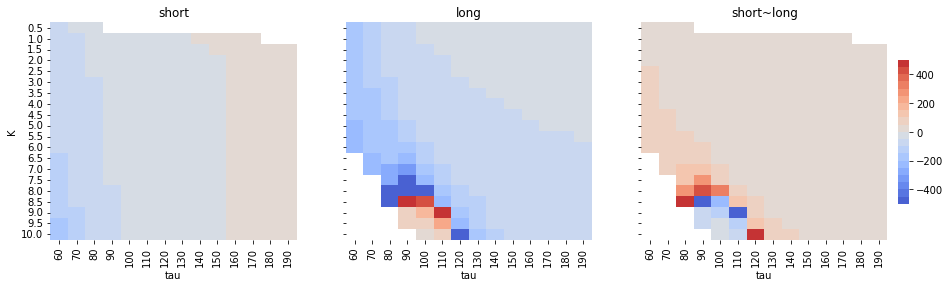

threshold 0.7
-5729.291804417044 11448.712108036589


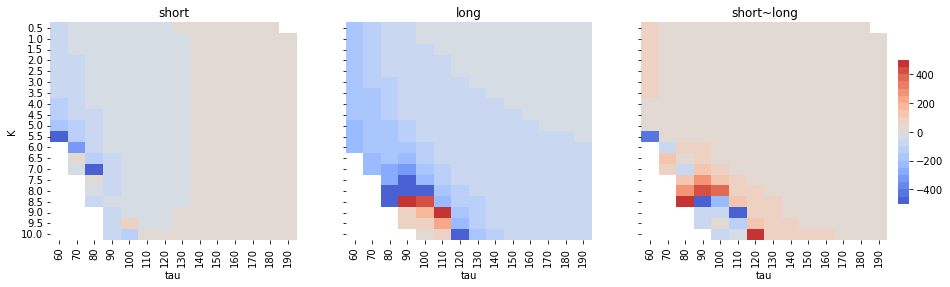

threshold 0.6
-1179.8166386541639 2014.1476755426547


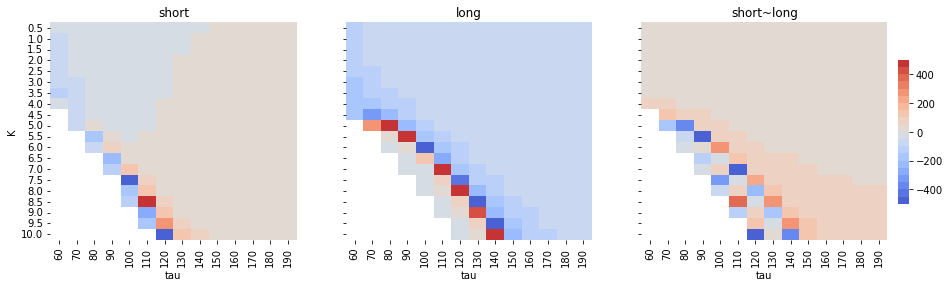

In [143]:
print('threshold', 0.8)
plot_ind_point(short_ktau08, long_ktau08)
print('threshold', 0.7)
plot_ind_point(short_ktau07, long_ktau07)
print('threshold', 0.6)
plot_ind_point(short_ktau06, long_ktau06)

threshold 0.8
-0.7814186174421873 1.2234295795647423


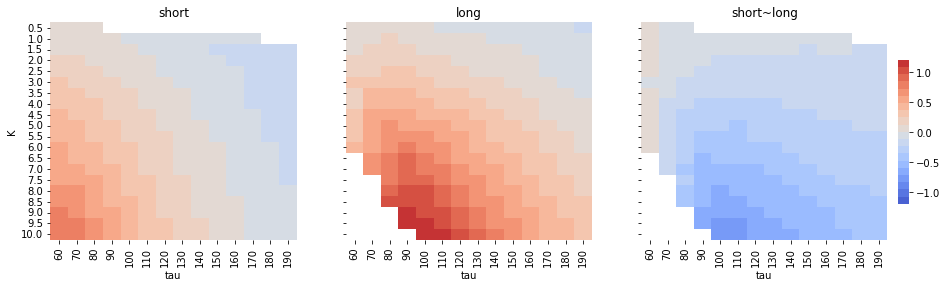

threshold 0.7
-0.3435957875864024 1.3678889865735142


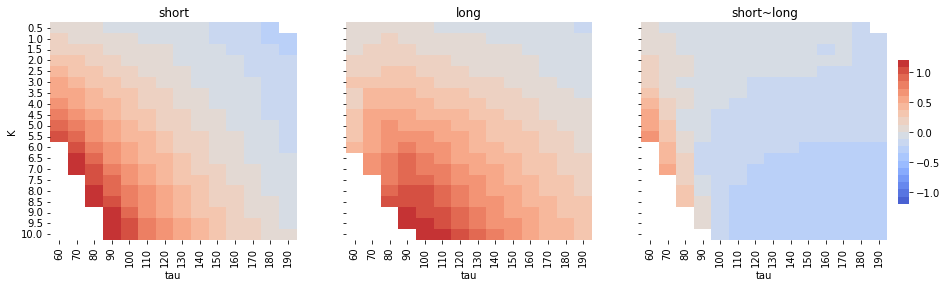

threshold 0.6
-0.5149012788129346 1.5095806267056064


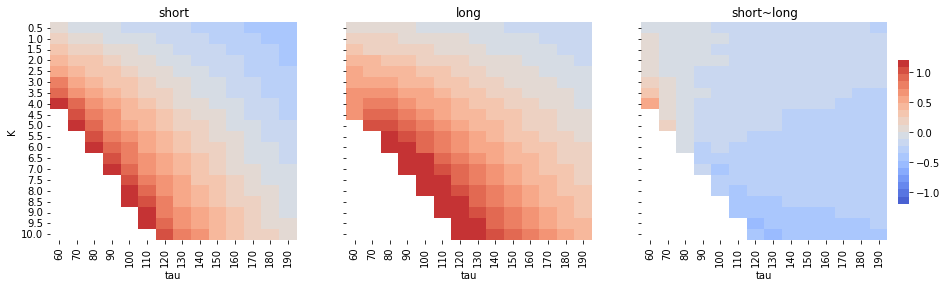

In [41]:
print('threshold', 0.8)
plot_slope(short_ktau08, long_ktau08)
print('threshold', 0.7)
plot_slope(short_ktau07, long_ktau07)
print('threshold', 0.6)
plot_slope(short_ktau06, long_ktau06)

threshold 0.8


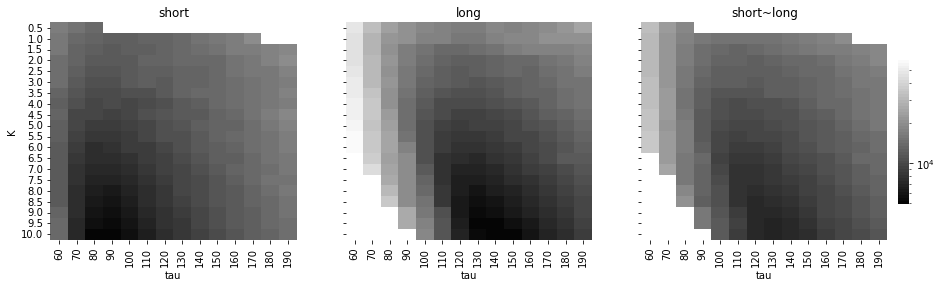

threshold 0.7


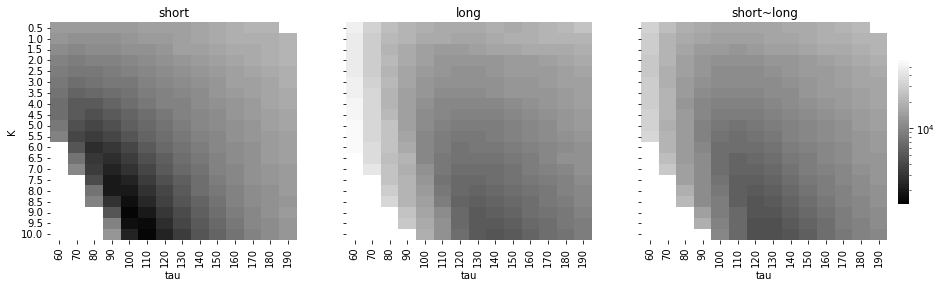

threshold 0.6


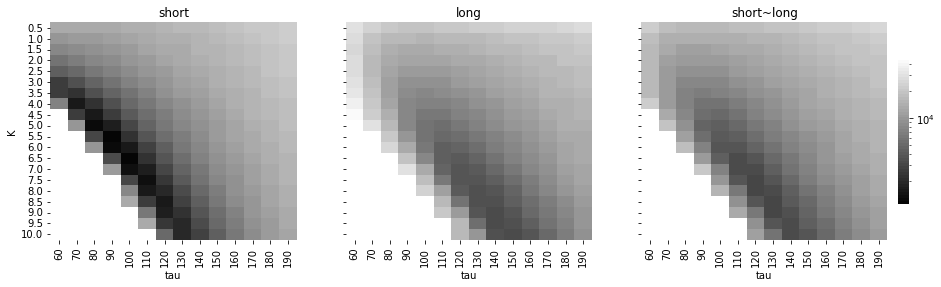

In [44]:
print('threshold', 0.8)
plot_mse(short_ktau08, long_ktau08)
print('threshold', 0.7)
plot_mse(short_ktau07, long_ktau07)
# 6. ,  7.5,  9. ,  8. ,  9. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,  0.5
print('threshold', 0.6)
plot_mse(short_ktau06, long_ktau06)

In [107]:
print(get_opt_K(short_ktau08, mse=True))
print(get_opt_K(long_ktau08, mse=True))

[(60, 8.5), (70, 10.0), (80, 10.0), (90, 10.0), (100, 10.0), (110, 10.0), (120, 10.0), (130, 10.0), (140, 10.0), (150, 10.0), (160, 10.0), (170, 9.5), (180, 10.0), (190, 10.0)]
[(60, 1.0), (70, 1.5), (80, 3.5), (90, 4.0), (100, 6.5), (110, 7.5), (120, 8.5), (130, 9.5), (140, 10.0), (150, 10.0), (160, 10.0), (170, 10.0), (180, 10.0), (190, 10.0)]


In [110]:
print(get_opt_K(short_ktau07, mse=True))
print(get_opt_K(long_ktau07, mse=True))

[(60, 4.5), (70, 5.5), (80, 6.0), (90, 8.0), (100, 9.0), (110, 10.0), (120, 10.0), (130, 10.0), (140, 10.0), (150, 10.0), (160, 10.0), (170, 10.0), (180, 10.0), (190, 10.0)]
[(60, 1.0), (70, 1.5), (80, 3.5), (90, 4.0), (100, 6.5), (110, 7.5), (120, 8.5), (130, 9.5), (140, 10.0), (150, 10.0), (160, 10.0), (170, 10.0), (180, 10.0), (190, 10.0)]


In [111]:
print(get_opt_K(short_ktau06, mse=True))
print(get_opt_K(long_ktau06, mse=True))

[(60, 3.5), (70, 4.0), (80, 5.0), (90, 5.5), (100, 6.5), (110, 7.5), (120, 8.5), (130, 10.0), (140, 10.0), (150, 10.0), (160, 10.0), (170, 10.0), (180, 10.0), (190, 10.0)]
[(60, 1.5), (70, 2.0), (80, 3.5), (90, 5.0), (100, 5.5), (110, 6.0), (120, 7.0), (130, 8.5), (140, 9.5), (150, 10.0), (160, 10.0), (170, 10.0), (180, 10.0), (190, 10.0)]


0.9214596239907958
0.7074449166484242


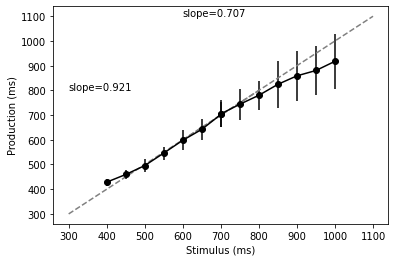

In [139]:
params = Params(ntrials=500, delay=700, tau=100, sigma=0.01, th=0.7)
expsim = ExperimentSimulation(params)

K = 9
exp_result = expsim.simulate(stimulus_lst_short, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

K = 6.5
exp_result = expsim.simulate(stimulus_lst_long, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

threshold 0.8


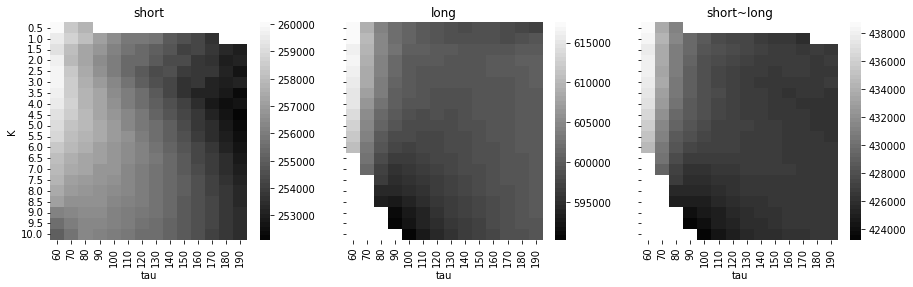

threshold 0.7


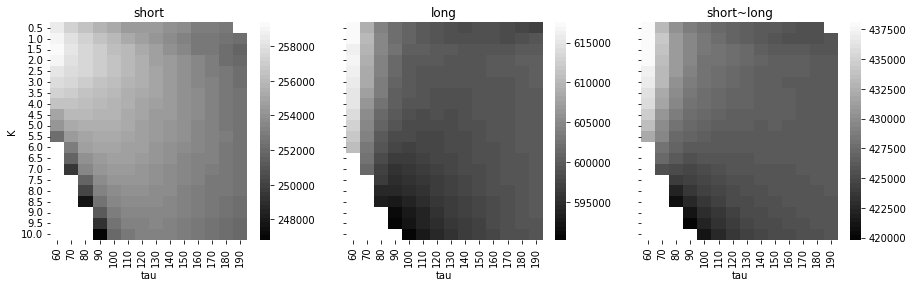

threshold 0.6


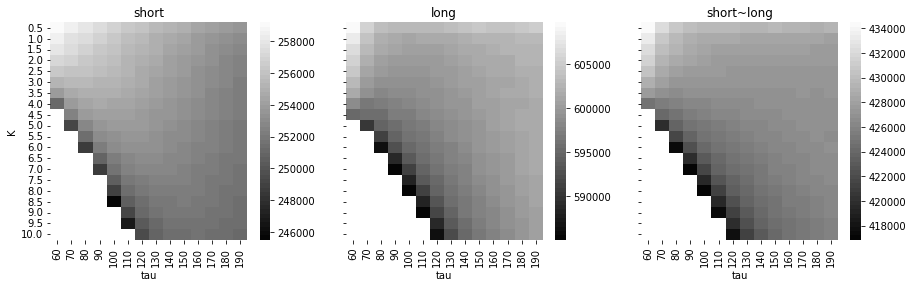

In [33]:
print('threshold', 0.8)
plot_mse_total(short_ktau08, long_ktau08)
print('threshold', 0.7)
plot_mse_total(short_ktau07, long_ktau07)
print('threshold', 0.6)
plot_mse_total(short_ktau06, long_ktau06)

# Parameter Space (K 8-18, sigma = 0.01)

In [120]:
K_lst = np.arange(8, 18, 0.5)
th_lst = np.arange(0.6, 0.75, 0.01)
delay_lst = np.arange(400, 1000, 50)
tau = np.arange(60, 200, 10)

print(len(K_lst), len(th_lst), len(delay_lst), len(tau))

20 16 12 14


In [121]:
path = '../results/'
short_ktau08, long_ktau08 = load_data(path+'SHORT_K8-18TAU_th08_del700-20220607-095036-output.pickle', 
                                      path+'LONG_K8-18TAU_th08_del700-20220603-163420-output.pickle')
short_ktau07, long_ktau07 = load_data(path+'SHORT_K8-18TAU_th07_del700-20220603-164917-output.pickle', 
                                      path+'LONG_K8-18TAU_th07_del700-20220603-170257-output.pickle')
short_ktau06, long_ktau06 = load_data(path+'SHORT_K8-18TAU_th06_del700-20220603-171654-output.pickle',
                                      path+'LONG_K8-18TAU_th06_del700-20220603-172926-output.pickle')

threshold 0.8
-3811.264553848741 6022.062763663883


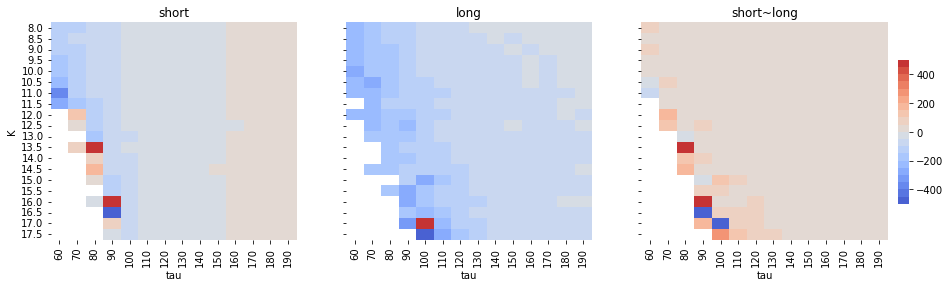

threshold 0.7
-28799.425898618334 18892.970195755333


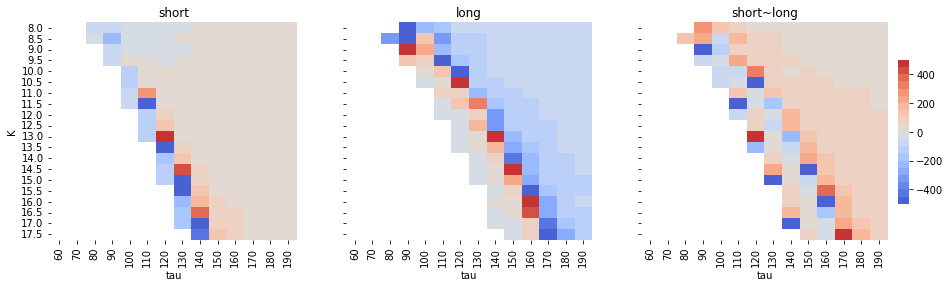

threshold 0.6
-119425.63505011542 238889.22889246762


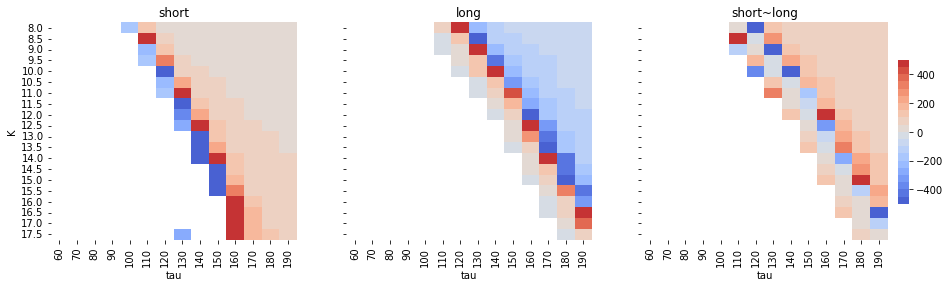

In [22]:
print('threshold', 0.8)
plot_ind_point(short_ktau08, long_ktau08)
print('threshold', 0.7)
plot_ind_point(short_ktau07, long_ktau07)
print('threshold', 0.6)
plot_ind_point(short_ktau06, long_ktau06)

threshold 0.8
-0.3755203962604212 1.2074507730345503


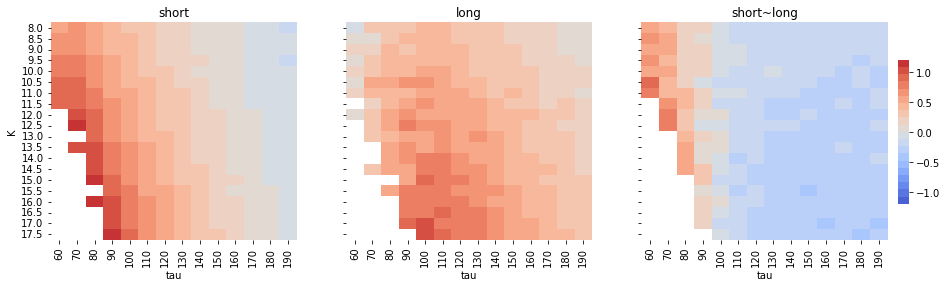

threshold 0.7
-0.6154258883643037 1.534901314080837


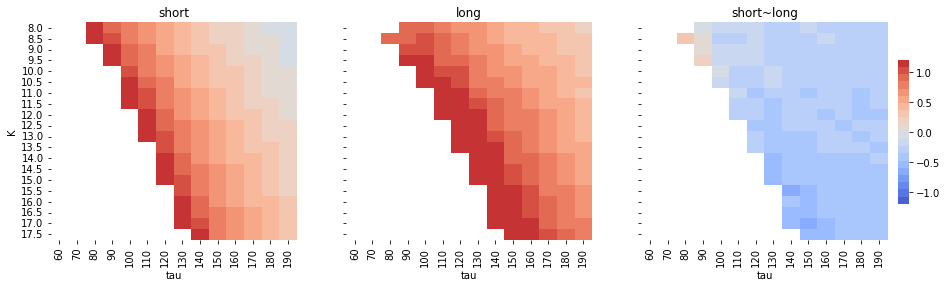

threshold 0.6
-0.8120747286787428 1.5622141012290096


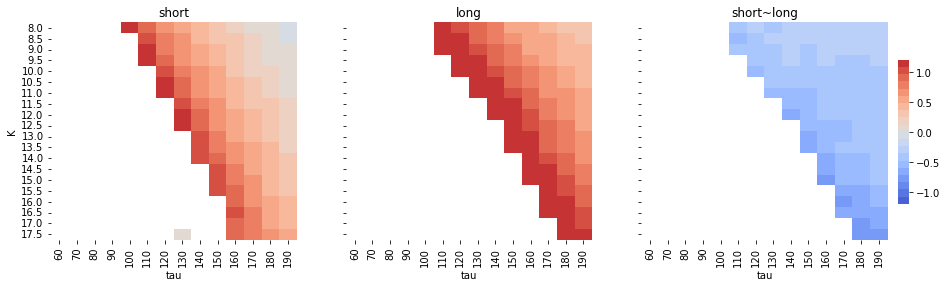

In [23]:
print('threshold', 0.8)
plot_slope(short_ktau08, long_ktau08)
print('threshold', 0.7)
plot_slope(short_ktau07, long_ktau07)
print('threshold', 0.6)
plot_slope(short_ktau06, long_ktau06)

threshold 0.8
2620.861148924095 100411.98825586514


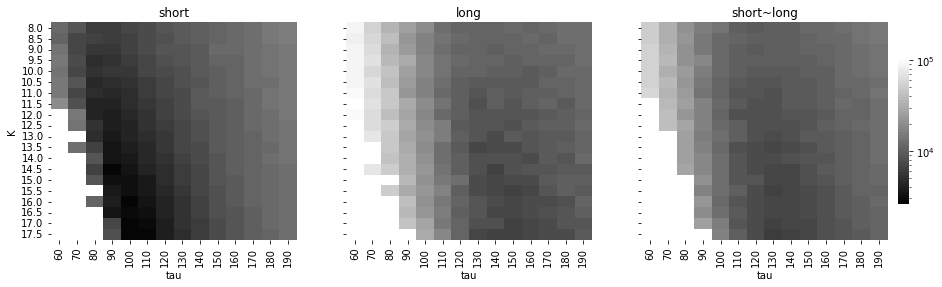

threshold 0.7
1043.8246370950092 38528.138632468246


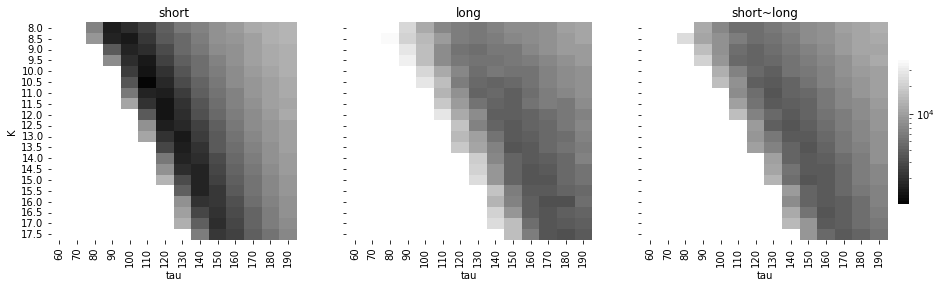

threshold 0.6
1635.276566884289 84677.90521181177


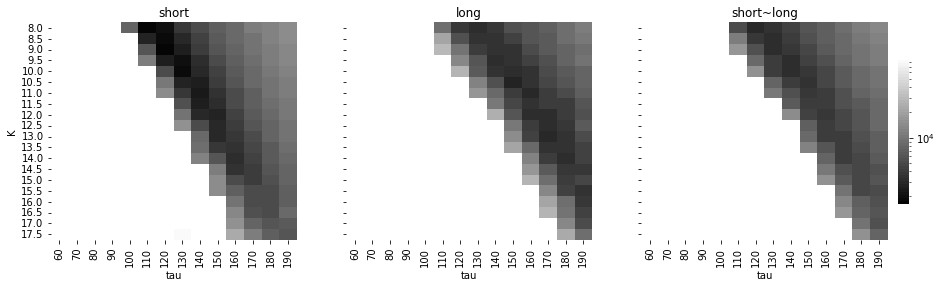

In [24]:
print('threshold', 0.8)
plot_mse(short_ktau08, long_ktau08)
print('threshold', 0.7)
plot_mse(short_ktau07, long_ktau07)
print('threshold', 0.6)
plot_mse(short_ktau06, long_ktau06)

In [126]:
print(get_opt_K(short_ktau08, mse=True))
print(get_opt_K(long_ktau08, mse=True))

[(60, 8.5), (70, 9.0), (80, 12.0), (90, 14.5), (100, 17.0), (110, 17.5), (120, 17.5), (130, 17.5), (140, 17.5), (150, 17.5), (160, 17.5), (170, 17.5), (180, 17.5), (190, 17.5)]
[(60, 8.5), (70, 8.0), (80, 9.0), (90, 8.5), (100, 8.5), (110, 12.0), (120, 12.5), (130, 13.5), (140, 14.5), (150, 17.0), (160, 17.0), (170, 17.5), (180, 17.5), (190, 17.0)]


In [129]:
print(get_opt_K(short_ktau07, mse=True))
print(get_opt_K(long_ktau07, mse=True))

[(60, 8.0), (70, 8.0), (80, 8.0), (90, 8.0), (100, 8.5), (110, 10.5), (120, 12.0), (130, 13.0), (140, 15.0), (150, 17.0), (160, 17.5), (170, 17.5), (180, 17.5), (190, 17.5)]
[(60, 8.0), (70, 8.0), (80, 8.5), (90, 8.5), (100, 8.0), (110, 8.0), (120, 9.0), (130, 11.0), (140, 12.0), (150, 13.5), (160, 15.0), (170, 16.0), (180, 16.0), (190, 17.5)]


In [130]:
print(get_opt_K(short_ktau06, mse=True))
print(get_opt_K(long_ktau06, mse=True))

[(60, 8.0), (70, 8.0), (80, 8.0), (90, 8.0), (100, 8.0), (110, 8.0), (120, 9.0), (130, 10.0), (140, 11.0), (150, 12.0), (160, 14.0), (170, 14.5), (180, 16.5), (190, 17.5)]
[(60, 8.0), (70, 8.0), (80, 8.0), (90, 8.0), (100, 8.0), (110, 8.0), (120, 8.0), (130, 8.0), (140, 9.5), (150, 10.5), (160, 11.0), (170, 13.0), (180, 14.0), (190, 15.5)]


threshold 0.8
250690.427402863 629500.1049250535


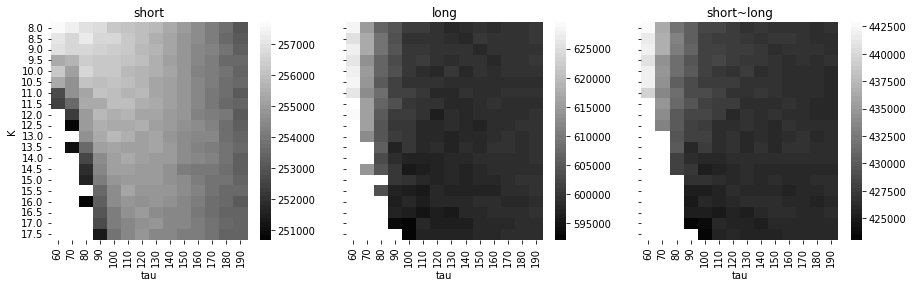

threshold 0.7
246617.61054766734 600052.644


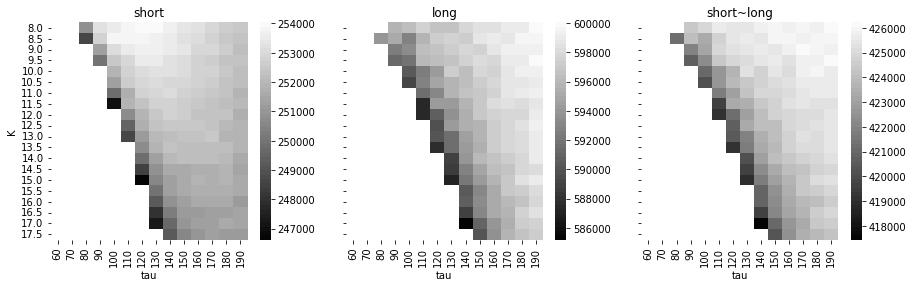

threshold 0.6
245038.1 601309.972


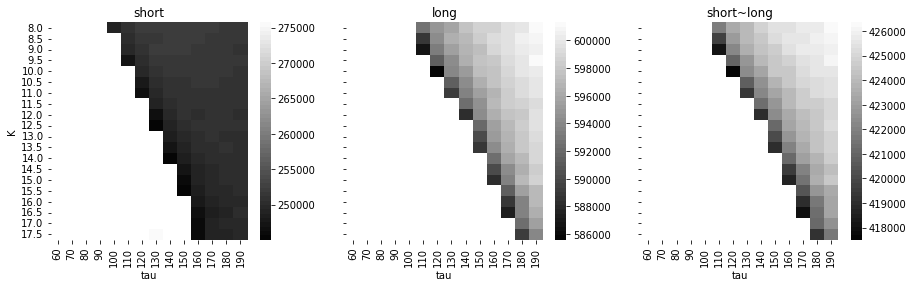

In [25]:
print('threshold', 0.8)
plot_mse_total(short_ktau08, long_ktau08)
print('threshold', 0.7)
plot_mse_total(short_ktau07, long_ktau07)
print('threshold', 0.6)
plot_mse_total(short_ktau06, long_ktau06)

# Parameter Space (K 2-20, sigma = 0.01)

In [131]:
K_lst = np.arange(1, 22, 1)
th_lst = np.arange(0.6, 0.75, 0.01)
delay_lst = np.arange(400, 1000, 50)
tau = np.arange(60, 200, 10)

print(len(K_lst), len(th_lst), len(delay_lst), len(tau))

21 16 12 14


In [133]:
path = '../results/'
short_ktau09, long_ktau09 = load_data(path+'SHORT_K1-21TAU_th09_del700-20220607-122526-output.pickle',
                                      path+'LONG_K1-21TAU_th09_del700-20220607-123614-output.pickle')
short_ktau08, long_ktau08 = load_data(path+'SHORT_K1-21TAU_th08_del700-20220607-110703-output.pickle', 
                                      path+'LONG_K1-21TAU_th08_del700-20220607-114054-output.pickle')
short_ktau07, long_ktau07 = load_data(path+'SHORT_K1-21TAU_th07_del700-20220607-120324-output.pickle', 
                                      path+'LONG_K1-21TAU_th07_del700-20220607-115320-output.pickle')

threshold 0.8
-58739.40899281486 58684.854851095


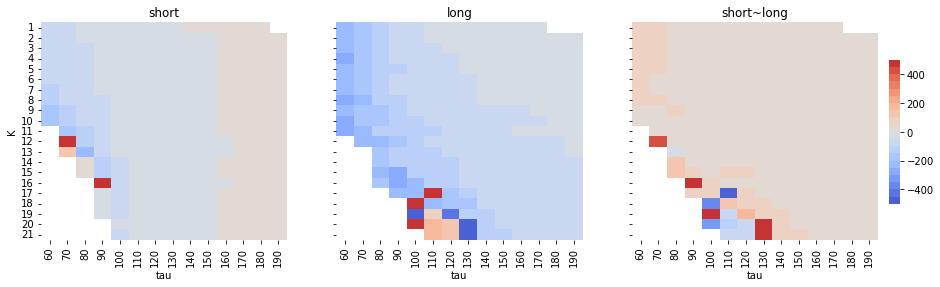

threshold 0.7
-10083.090086375834 20208.214105972376


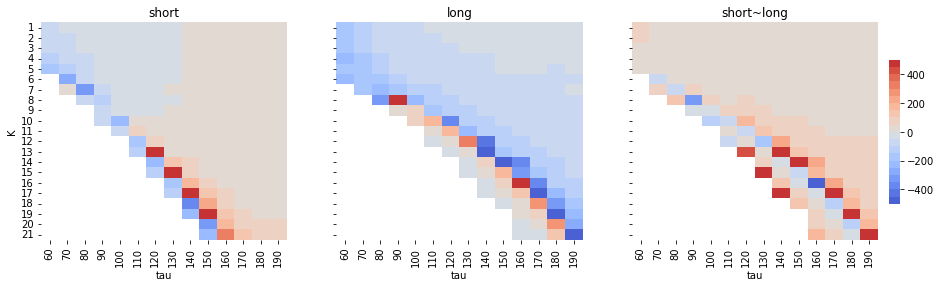

In [40]:
print('threshold', 0.8)
plot_ind_point(short_ktau08, long_ktau08)
print('threshold', 0.7)
plot_ind_point(short_ktau07, long_ktau07)

threshold 0.8
-0.4716899756050298 1.229320858524066


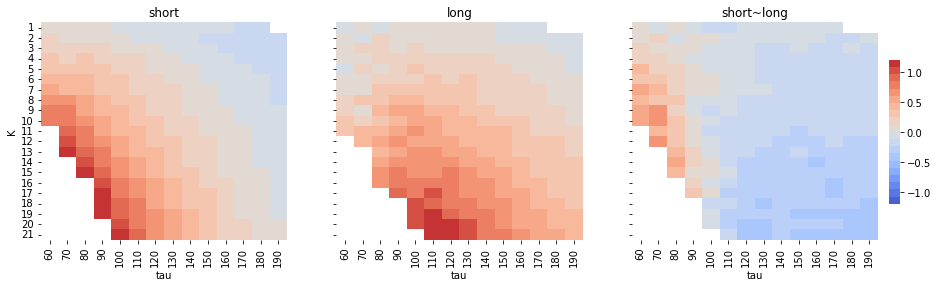

threshold 0.7
-0.6897718896281438 1.591016080186787


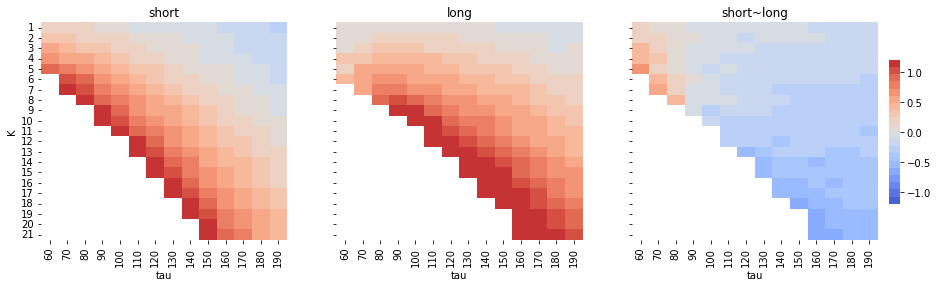

In [39]:
print('threshold', 0.8)
plot_slope(short_ktau08, long_ktau08)
print('threshold', 0.7)
plot_slope(short_ktau07, long_ktau07)

threshold 0.9
threshold 0.8
2337.9751299520467 97161.48265474546


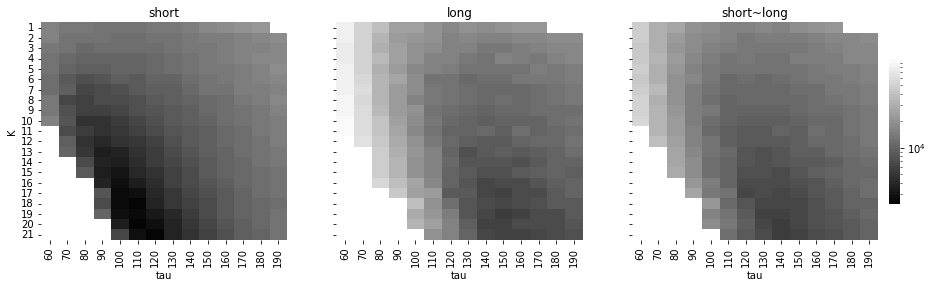

threshold 0.7
1335.3527717600211 69758.0248023876


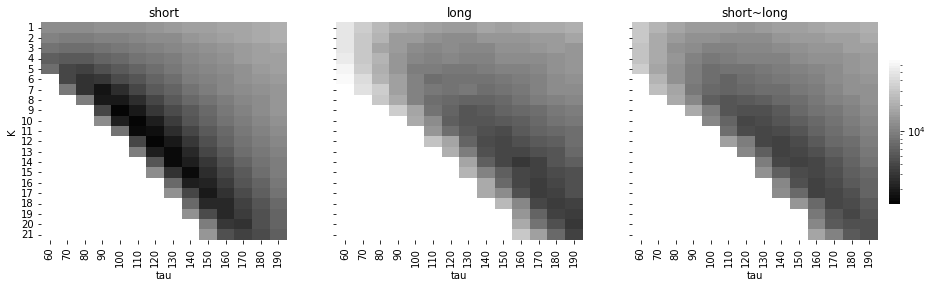

In [37]:
print('threshold', 0.9)
#plot_mse(short_ktau09, long_ktau09)
print('threshold', 0.8)
plot_mse(short_ktau08, long_ktau08)
print('threshold', 0.7)
plot_mse(short_ktau07, long_ktau07)

In [134]:
print(get_opt_K(short_ktau08, mse=True))
print(get_opt_K(long_ktau08, mse=True))

[(60, 6), (70, 8), (80, 12), (90, 13), (100, 17), (110, 20), (120, 21), (130, 20), (140, 21), (150, 21), (160, 21), (170, 20), (180, 21), (190, 18)]
[(60, 4), (70, 1), (80, 3), (90, 5), (100, 8), (110, 11), (120, 17), (130, 13), (140, 20), (150, 19), (160, 21), (170, 21), (180, 21), (190, 21)]


In [135]:
print(get_opt_K(short_ktau07, mse=True))
print(get_opt_K(long_ktau07, mse=True))

[(60, 4), (70, 5), (80, 6), (90, 7), (100, 9), (110, 10), (120, 12), (130, 14), (140, 15), (150, 17), (160, 19), (170, 20), (180, 21), (190, 21)]
[(60, 2), (70, 2), (80, 3), (90, 4), (100, 5), (110, 8), (120, 10), (130, 10), (140, 12), (150, 13), (160, 14), (170, 16), (180, 18), (190, 20)]


0.8016192053565744
0.5405185909424125


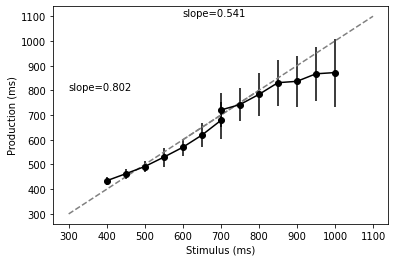

In [149]:
params = Params(ntrials=500, delay=700, tau=110, sigma=0.01, th=0.8)
expsim = ExperimentSimulation(params)

K = 20
exp_result = expsim.simulate(stimulus_lst_short, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

K = 11
exp_result = expsim.simulate(stimulus_lst_long, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

threshold 0.9
threshold 0.8
907.5529454865442 51833.609020658834


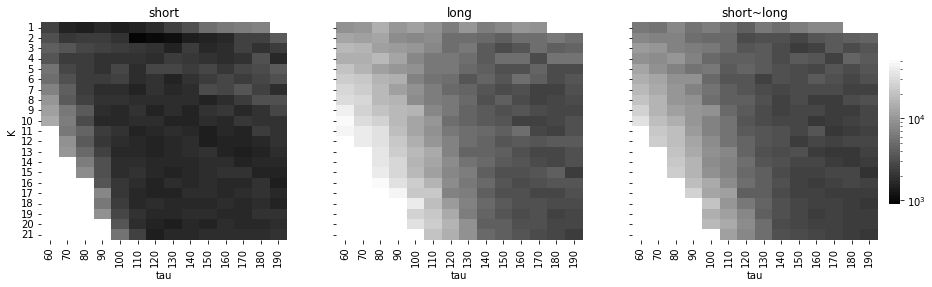

threshold 0.7
743.4996184250724 47925.568655758434


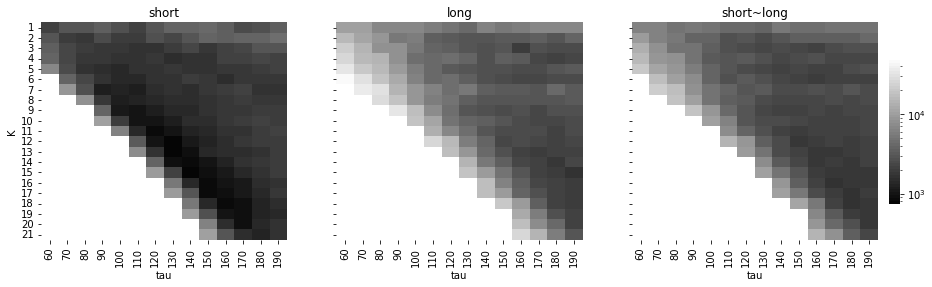

In [145]:
print('threshold', 0.9)
#plot_mse(short_ktau09, long_ktau09)
print('threshold', 0.8)
plot_mse(short_ktau08, long_ktau08, 'var')
print('threshold', 0.7)
plot_mse(short_ktau07, long_ktau07, 'var')

threshold 0.8
248719.20328542095 631235.3029045643


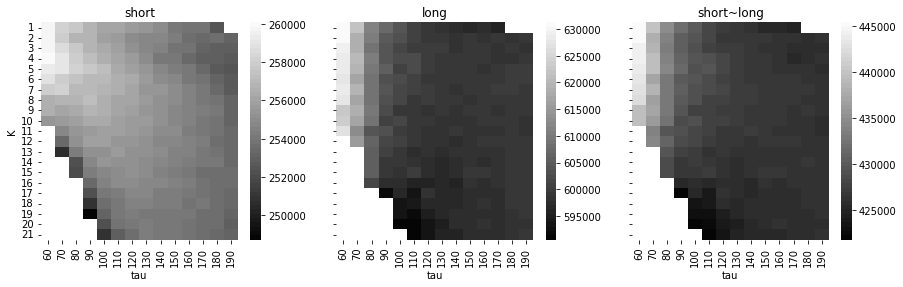

threshold 0.7
245205.48163265307 619965.9034205232


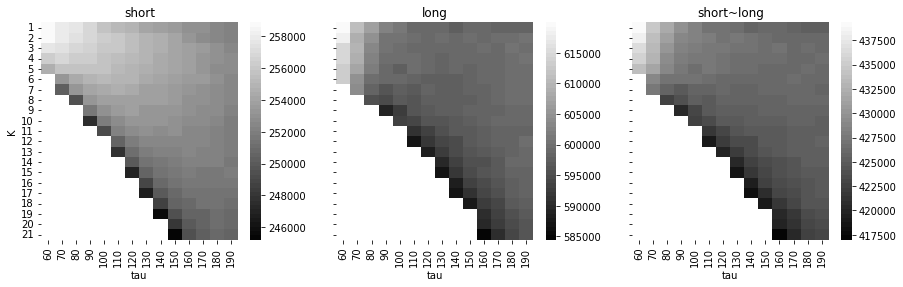

In [38]:
print('threshold', 0.8)
plot_mse_total(short_ktau08, long_ktau08)
print('threshold', 0.7)
plot_mse_total(short_ktau07, long_ktau07)

# Parameter Space (K 3.5-15, sigma = 0.02)

In [226]:
K_lst = np.arange(3.5, 15.5, 0.5)
tau = np.arange(90, 120, 5)

print(len(K_lst), len(tau))

24 6


In [232]:
path = '../results/'
short_ktau065, long_ktau065 = load_data(path+'SHORT_K4-15TAU_th065_del700_sig02-20220617-163315-output.pickle',
                                      path+'LONG_K4-15TAU_th065_del700_sig02-20220617-162513-output.pickle')
short_ktau07, long_ktau07 = load_data(path+'SHORT_K4-15TAU_th07_del700_sig02-20220617-160747-output.pickle', 
                                      path+'LONG_K4-15TAU_th07_del700_sig02-20220617-161139-output.pickle')
short_ktau075, long_ktau075 = load_data(path+'SHORT_K4-15TAU_th075_del700_sig02_fix_seed-20220617-182536-output.pickle', 
                                      path+'LONG_K4-15TAU_th075_del700_sig02_fix_seed-20220617-181956-output.pickle')

threshold 0.75
-1913.150381937 9220.477413399292


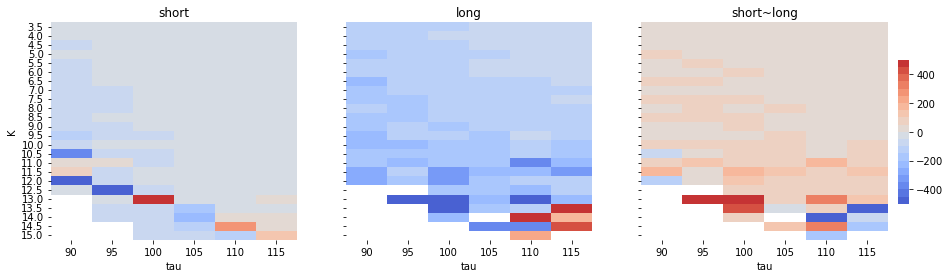

threshold 0.7
-3017.5468001564514 5897.404830077531


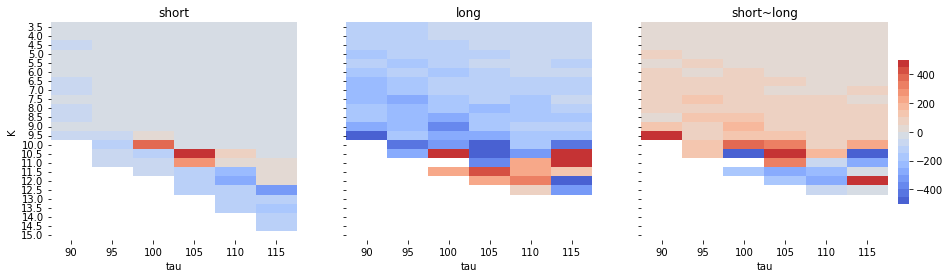

threshold 0.65
-17485.34773834863 8666.45163048566


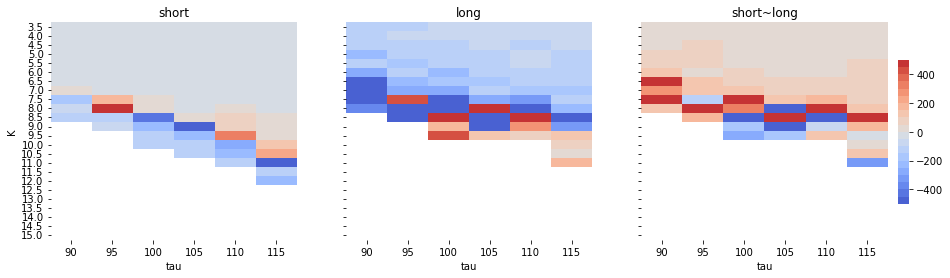

In [229]:
print('threshold', 0.75)
plot_ind_point(short_ktau075, long_ktau075)
print('threshold', 0.7)
plot_ind_point(short_ktau07, long_ktau07)
print('threshold', 0.65)
plot_ind_point(short_ktau065, long_ktau065)

threshold 0.75
-0.2747622737101518 1.2189526769780372


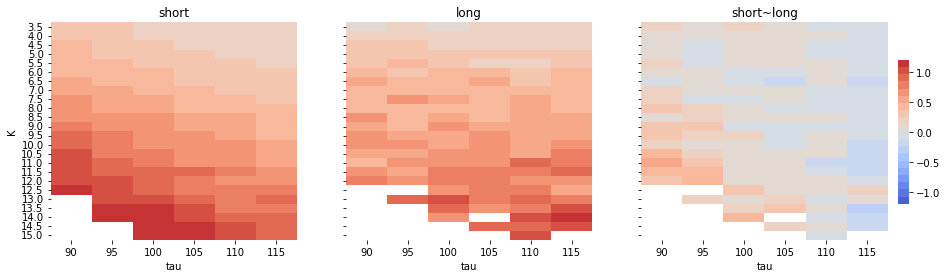

threshold 0.7
-0.26352036742843654 1.2800251948230994


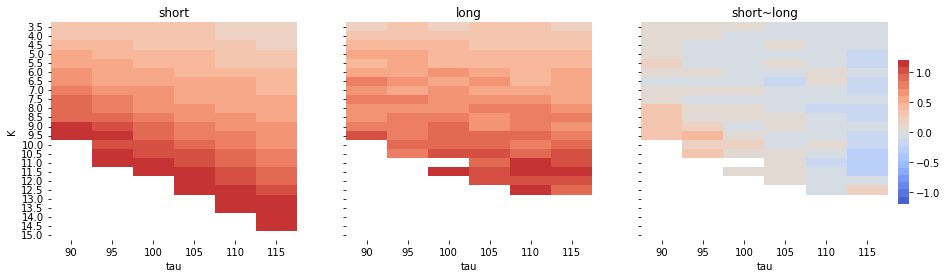

threshold 0.65
-0.3089155207210452 1.2789010196501103


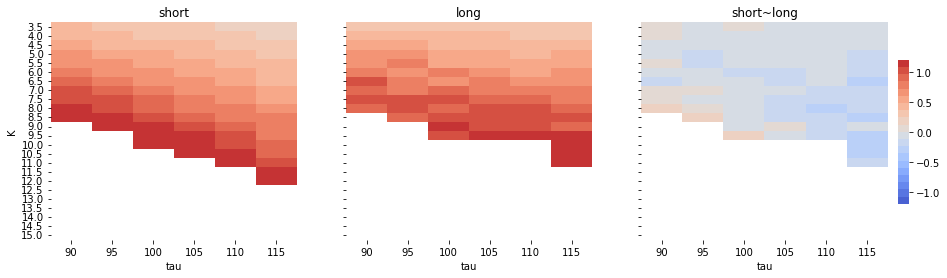

In [230]:
print('threshold', 0.75)
plot_slope(short_ktau075, long_ktau075)
print('threshold', 0.7)
plot_slope(short_ktau07, long_ktau07)
print('threshold', 0.65)
plot_slope(short_ktau065, long_ktau065)

threshold 0.75
3802.614633371331 59755.158085831594


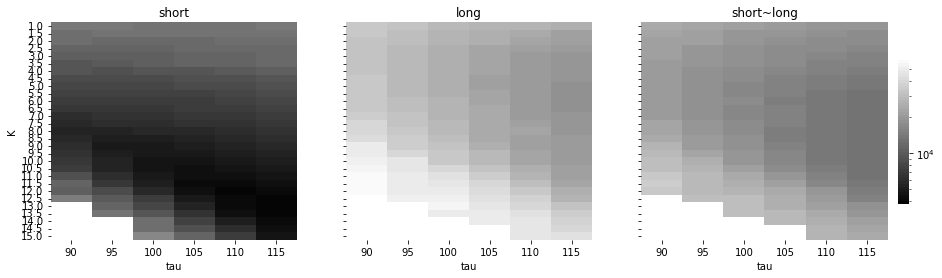

In [234]:
K_lst = np.arange(1, 15.5, 0.5)
print('threshold', 0.75)
plot_mse(short_ktau075, long_ktau075)

threshold 0.75
3731.38336715003 58116.97693973205


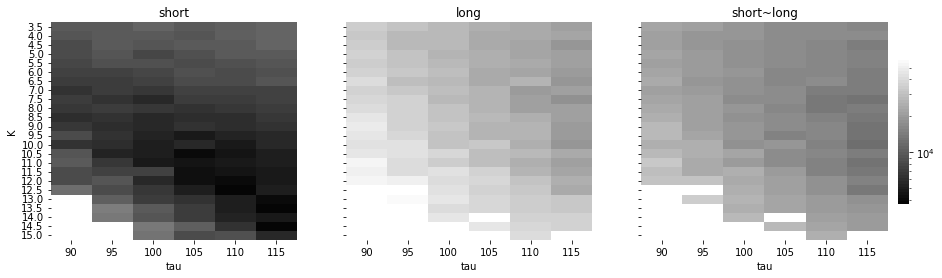

threshold 0.7
3345.524342134614 53618.59617102915


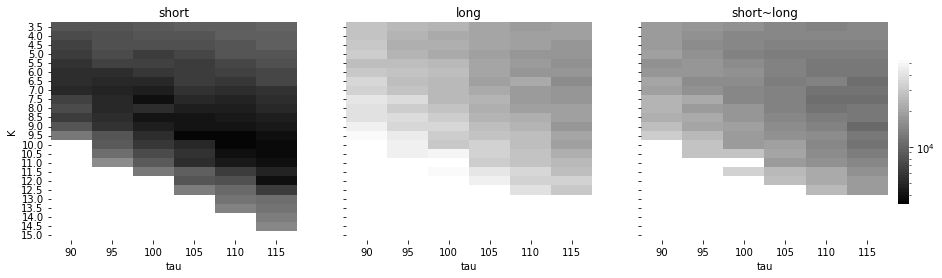

threshold 0.65
3329.0303805532785 48919.16367675855


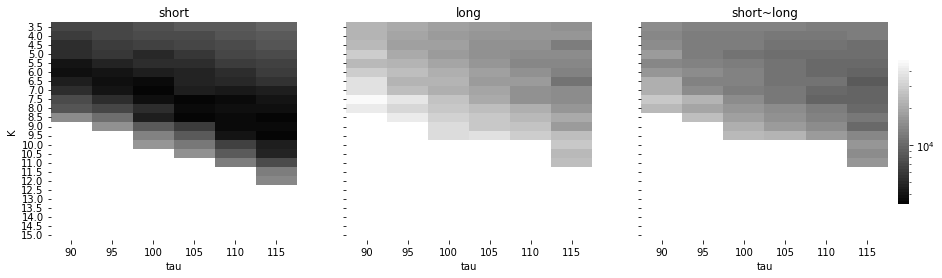

In [ ]:
print('threshold', 0.75)
plot_mse(short_ktau075, long_ktau075)
print('threshold', 0.7)
plot_mse(short_ktau07, long_ktau07)
print('threshold', 0.65)
plot_mse(short_ktau065, long_ktau065)

In [134]:
print(get_opt_K(short_ktau08, mse=True))
print(get_opt_K(long_ktau08, mse=True))

[(60, 6), (70, 8), (80, 12), (90, 13), (100, 17), (110, 20), (120, 21), (130, 20), (140, 21), (150, 21), (160, 21), (170, 20), (180, 21), (190, 18)]
[(60, 4), (70, 1), (80, 3), (90, 5), (100, 8), (110, 11), (120, 17), (130, 13), (140, 20), (150, 19), (160, 21), (170, 21), (180, 21), (190, 21)]


In [135]:
print(get_opt_K(short_ktau07, mse=True))
print(get_opt_K(long_ktau07, mse=True))

[(60, 4), (70, 5), (80, 6), (90, 7), (100, 9), (110, 10), (120, 12), (130, 14), (140, 15), (150, 17), (160, 19), (170, 20), (180, 21), (190, 21)]
[(60, 2), (70, 2), (80, 3), (90, 4), (100, 5), (110, 8), (120, 10), (130, 10), (140, 12), (150, 13), (160, 14), (170, 16), (180, 18), (190, 20)]


0.8016192053565744
0.5405185909424125


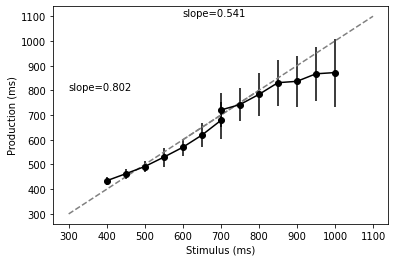

In [149]:
params = Params(ntrials=500, delay=700, tau=110, sigma=0.01, th=0.8)
expsim = ExperimentSimulation(params)

K = 20
exp_result = expsim.simulate(stimulus_lst_short, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

K = 11
exp_result = expsim.simulate(stimulus_lst_long, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

threshold 0.9
threshold 0.8
907.5529454865442 51833.609020658834


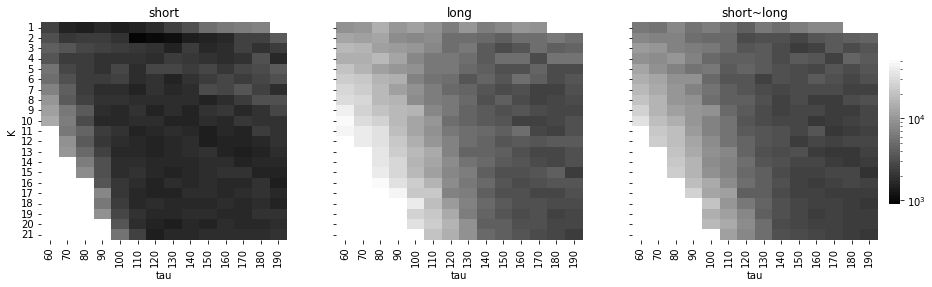

threshold 0.7
743.4996184250724 47925.568655758434


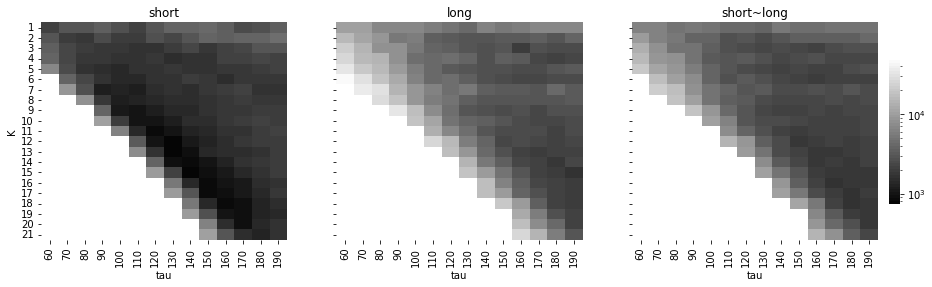

In [145]:
print('threshold', 0.9)
#plot_mse(short_ktau09, long_ktau09)
print('threshold', 0.8)
plot_mse(short_ktau08, long_ktau08, 'var')
print('threshold', 0.7)
plot_mse(short_ktau07, long_ktau07, 'var')

threshold 0.8
248719.20328542095 631235.3029045643


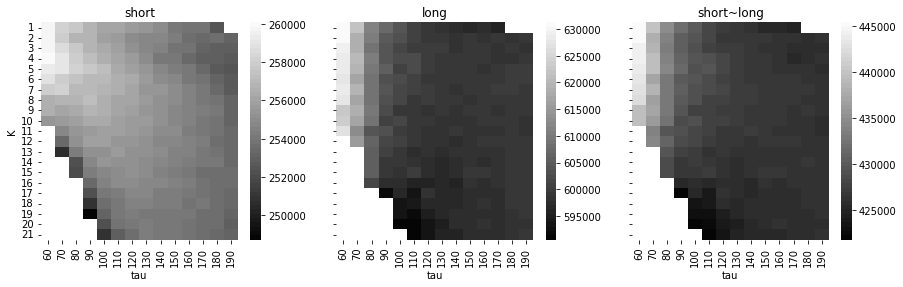

threshold 0.7
245205.48163265307 619965.9034205232


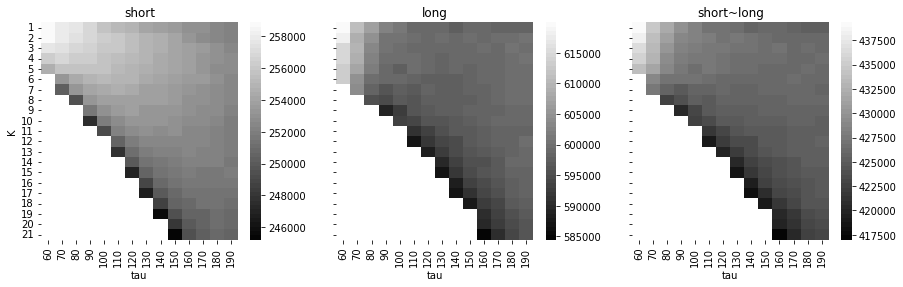

In [38]:
print('threshold', 0.8)
plot_mse_total(short_ktau08, long_ktau08)
print('threshold', 0.7)
plot_mse_total(short_ktau07, long_ktau07)

## Optimized

0.8034037266071195
0.40273043511423995


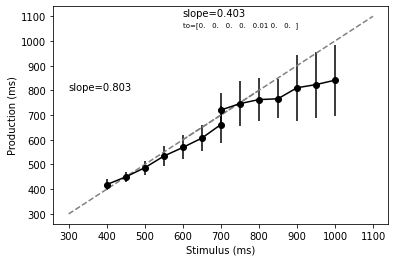

In [182]:
params = Params(ntrials=500, delay=700, tau=80, sigma=0.01, th=0.7)
expsim = ExperimentSimulation(params)

K = 6
exp_result = expsim.simulate(stimulus_lst_short, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

K = 3.5
exp_result = expsim.simulate(stimulus_lst_long, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

0.7764425015831803
0.3517041916030438


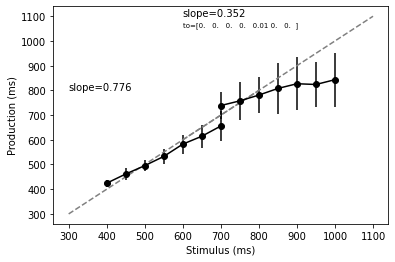

In [165]:
params = Params(ntrials=500, delay=700, tau=90, sigma=0.01, th=0.7)
expsim = ExperimentSimulation(params)

K = 7
exp_result = expsim.simulate(stimulus_lst_short, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

K = 4
exp_result = expsim.simulate(stimulus_lst_long, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

0.8386537492256182
0.46835823846515534


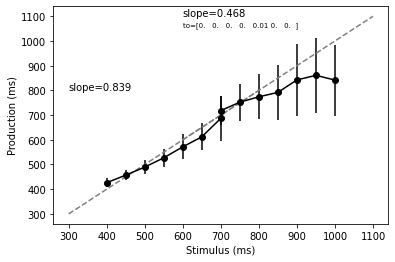

In [169]:
params = Params(ntrials=500, delay=700, tau=100, sigma=0.01, th=0.8)
expsim = ExperimentSimulation(params)

K = 17
exp_result = expsim.simulate(stimulus_lst_short, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

K = 8.5
exp_result = expsim.simulate(stimulus_lst_long, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

0.8192410854963001
0.6891346873115233


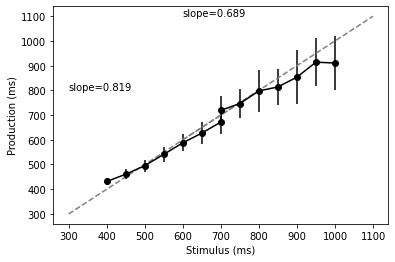

In [172]:
params = Params(ntrials=500, delay=700, tau=100, sigma=0.01, th=0.7)
expsim = ExperimentSimulation(params)

K = 8.5
exp_result = expsim.simulate(stimulus_lst_short, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

K = 6
exp_result = expsim.simulate(stimulus_lst_long, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

0.8024221093868587
0.5467100095032136


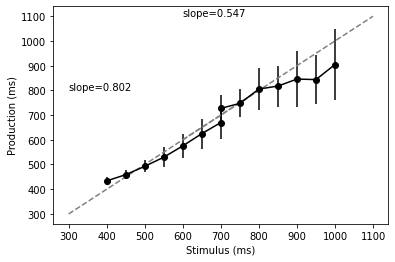

In [174]:
params = Params(ntrials=500, delay=700, tau=110, sigma=0.01, th=0.8)
expsim = ExperimentSimulation(params)

K = 20
exp_result = expsim.simulate(stimulus_lst_short, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

K = 11
exp_result = expsim.simulate(stimulus_lst_long, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

0.8005142019666446
0.7966471863822979


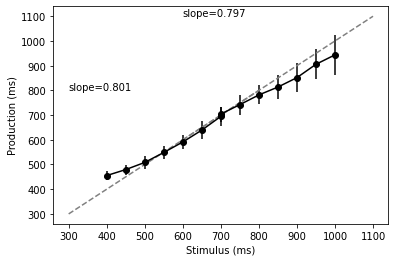

In [177]:
params = Params(ntrials=500, delay=700, tau=110, sigma=0.01, th=0.6)
expsim = ExperimentSimulation(params)

K = 7.5
exp_result = expsim.simulate(stimulus_lst_short, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

K = 6
exp_result = expsim.simulate(stimulus_lst_long, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

0.7305985478919332
0.8279301905571541


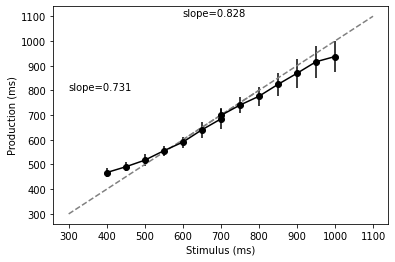

In [179]:
params = Params(ntrials=500, delay=700, tau=120, sigma=0.01, th=0.6)
expsim = ExperimentSimulation(params)

K = 8.5
exp_result = expsim.simulate(stimulus_lst_short, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

K = 7
exp_result = expsim.simulate(stimulus_lst_long, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

0.6960426868566295
0.9697915006190487


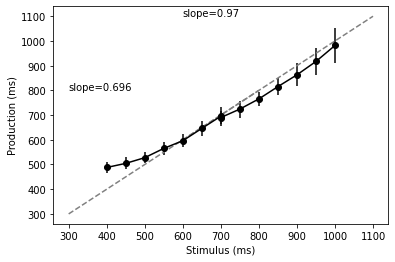

In [184]:
params = Params(ntrials=500, delay=700, tau=140, sigma=0.01, th=0.6)
expsim = ExperimentSimulation(params)

K = 11
exp_result = expsim.simulate(stimulus_lst_short, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

K = 9.5
exp_result = expsim.simulate(stimulus_lst_long, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()
print(exp_result.create_behavioral_data().slope)

# Variability of eperiments

In [11]:
def extract(short, long):
    slope_short, slope_long, ind_short, ind_long, mse_short, mse_long = [], [], [], [], [], []
    for i in range(len(short)):
        slope_short.append(short[i]['slope'])
        slope_long.append(long[i]['slope'])
        ind_short.append(short[i]['ind_point'])
        ind_long.append(long[i]['ind_point'])
        mse_short.append(short[i]['bias2']+short[i]['var'])
        mse_long.append(long[i]['bias2']+long[i]['var'])
    return slope_short, slope_long, ind_short, ind_long, mse_short, mse_long

In [16]:
short_stat, long_stat = load_data('../results/SHORT_SAME_K8_TAU100_TH08_DEL700-20220602-092841-output.pickle',
                                  '../results/LONG_SAME_K8_TAU100_TH08_DEL700-20220602-093934-output.pickle')
short_var, long_var = load_data('../results/SHORT_VAR_K8_TAU100_TH08_DEL700-20220526-170830-output.pickle',
                                  '../results/LONG_VAR_K8_TAU100_TH08_DEL700-20220526-165306-output.pickle')

fixed K=8, tau=100, th=0.8, del=700, sig = 0.01


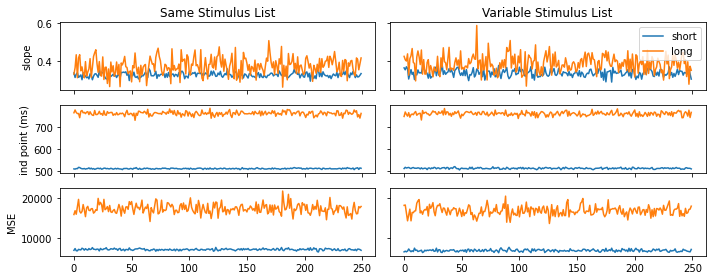

In [17]:
print('fixed K=8, tau=100, th=0.8, del=700, sig = 0.01')
fig, axs = plt.subplots(3,2, sharey='row', sharex=True, figsize=(10,4))

slope_short, slope_long, ind_short, ind_long, mse_short, mse_long = extract(short_stat, long_stat)

axs.flatten()[0].plot(slope_short, label='short')
axs.flatten()[0].plot(slope_long, label='long')
axs.flatten()[0].set_ylabel('slope')
axs.flatten()[0].set_title('Same Stimulus List')

axs.flatten()[2].plot(ind_short)
axs.flatten()[2].plot(ind_long)
axs.flatten()[2].set_ylabel('ind point (ms)')

axs.flatten()[4].plot(mse_short)
axs.flatten()[4].plot(mse_long)
axs.flatten()[4].set_ylabel('MSE')

slope_short, slope_long, ind_short, ind_long, mse_short, mse_long = extract(short_var, long_var)

axs.flatten()[1].plot(slope_short, label='short')
axs.flatten()[1].plot(slope_long, label='long')
axs.flatten()[1].legend()
axs.flatten()[1].set_title('Variable Stimulus List')

axs.flatten()[3].plot(ind_short)
axs.flatten()[3].plot(ind_long)

axs.flatten()[5].plot(mse_short)
axs.flatten()[5].plot(mse_long)

#plt.subplots_adjust(left=None, bottom=None, right=1.15, top=None, wspace=None, hspace=None)
plt.tight_layout()

# Optimizing $\sigma$ and CV 

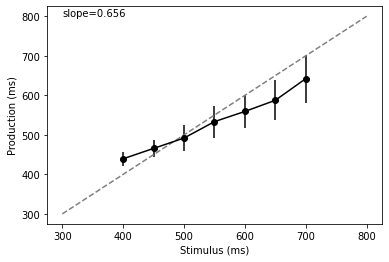

In [129]:
params = Params(ntrials=500, delay=700, tau=100, sigma=0.01, th=0.8)
expsim = ExperimentSimulation(params)

K = 14
exp_result = expsim.simulate(stimulus_lst_short, K)
plot = exp_result.create_behavioral_plot()
plot.plot_behavior()

In [213]:
sigma_lst = [0,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.05,0.06,0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25]

In [200]:
K = 8.5
stds_s = []

for sigma in sigma_lst:

    params = Params(ntrials=500, delay=700, tau=100, th=0.7, sigma = sigma)
    expsim = ExperimentSimulation(params)
    exp_result = expsim.simulate(stimulus_lst_short, K)
    beh_result = exp_result.create_behavioral_data()
    stds_s.append(beh_result.production_stds)

In [201]:
K = 6
stds_l = []

for sigma in sigma_lst:

    params = Params(ntrials=500, delay=700, tau=100, th=0.7, sigma = sigma)
    expsim = ExperimentSimulation(params)
    exp_result = expsim.simulate(stimulus_lst_long, K)
    beh_result = exp_result.create_behavioral_data()
    stds_l.append(beh_result.production_stds)

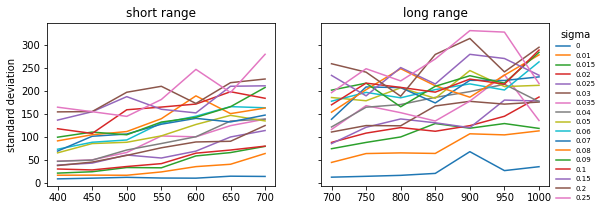

In [206]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(9,3))

for lst, sigma in zip(stds_s, sigma_lst):
    ax[0].plot(stimulus_range_s, lst, label=str(sigma))
ax[0].set_title('short range')
ax[0].set_ylabel('standard deviation')

for lst, sigma in zip(stds_l, sigma_lst):
    ax[1].plot(stimulus_range_l, lst, label=str(sigma))
ax[1].set_title('long range')

ax[1].legend(bbox_to_anchor=(1, 1), title='sigma', frameon=False,  prop={'size': 7})

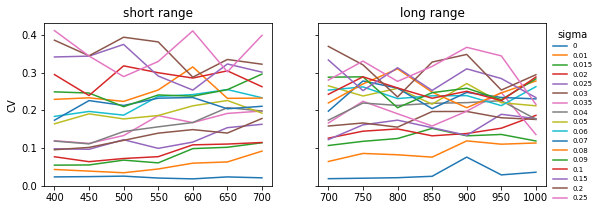

In [207]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(9,3))

for lst, sigma in zip(np.array(stds_s)/np.array(stimulus_range_s), sigma_lst):
    ax[0].plot(stimulus_range_s, lst, label=str(sigma))
ax[0].set_title('short range')
ax[0].set_ylabel('CV')

for lst, sigma in zip(np.array(stds_l)/np.array(stimulus_range_l), sigma_lst):
    ax[1].plot(stimulus_range_l, lst, label=str(sigma))
ax[1].set_title('long range')

ax[1].legend(bbox_to_anchor=(1, 1), title='sigma', frameon=False,  prop={'size': 7})

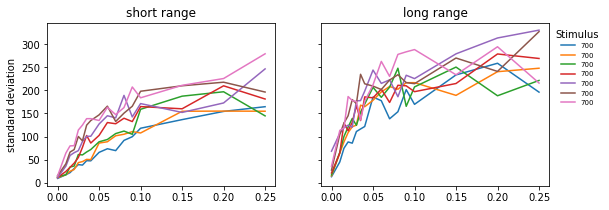

In [212]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(9,3))

for lst, sigma in zip(np.array(stds_s).T, stimulus_range_s):
    ax[0].plot(sigma_lst, lst, label=str(stimulus))
ax[0].set_title('short range')
ax[0].set_ylabel('standard deviation')

for lst, sigma in zip(np.array(stds_l).T, stimulus_range_l):
    ax[1].plot(sigma_lst, lst, label=str(stimulus))
ax[1].set_title('long range')

ax[1].legend(bbox_to_anchor=(1, 1), title='Stimulus', frameon=False,  prop={'size': 7})

In [216]:
K = 8.5

stds_s_mean = []
for sigma in sigma_lst:
    stds_si = []
    for i in range(11):
        params = Params(ntrials=500, delay=700, tau=100, th=0.7, sigma = sigma)
        expsim = ExperimentSimulation(params)
        exp_result = expsim.simulate(stimulus_lst_short, K)
        beh_result = exp_result.create_behavioral_data()
        stds_si.append(beh_result.production_stds)
    stds_s_mean.append(np.mean(stds_si, axis=0))

In [217]:
K = 6
stds_l_mean = []

for sigma in sigma_lst:
    stds_li = []
    for i in range(11):
        params = Params(ntrials=500, delay=700, tau=100, th=0.7, sigma = sigma)
        expsim = ExperimentSimulation(params)
        exp_result = expsim.simulate(stimulus_lst_long, K)
        beh_result = exp_result.create_behavioral_data()
        stds_li.append(beh_result.production_stds)
    stds_l_mean.append(np.mean(stds_li, axis=0))

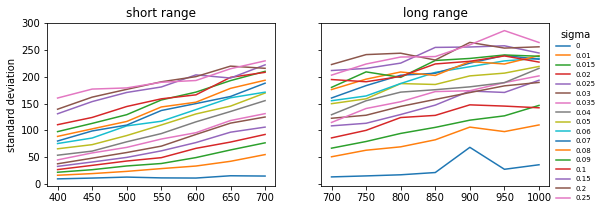

In [218]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(9,3))

for lst, sigma in zip(stds_s_mean, sigma_lst):
    ax[0].plot(stimulus_range_s, lst, label=str(sigma))
ax[0].set_title('short range')
ax[0].set_ylabel('standard deviation')

for lst, sigma in zip(stds_l_mean, sigma_lst):
    ax[1].plot(stimulus_range_l, lst, label=str(sigma))
ax[1].set_title('long range')

ax[1].legend(bbox_to_anchor=(1, 1), title='sigma', frameon=False,  prop={'size': 7})

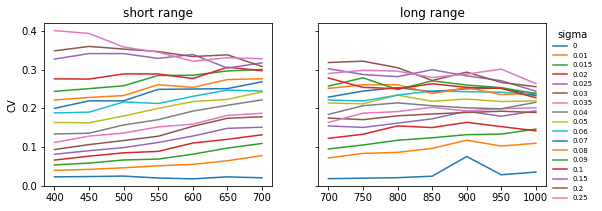

In [219]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(9,3))

for lst, sigma in zip(np.array(stds_s_mean)/np.array(stimulus_range_s), sigma_lst):
    ax[0].plot(stimulus_range_s, lst, label=str(sigma))
ax[0].set_title('short range')
ax[0].set_ylabel('CV')

for lst, sigma in zip(np.array(stds_l_mean)/np.array(stimulus_range_l), sigma_lst):
    ax[1].plot(stimulus_range_l, lst, label=str(sigma))
ax[1].set_title('long range')

ax[1].legend(bbox_to_anchor=(1, 1), title='sigma', frameon=False,  prop={'size': 7})

In [222]:
np.mean(np.array(stds_s_mean)/np.array(stimulus_range_s), axis=1)

array([0.0221595 , 0.05429255, 0.07689181, 0.09725781, 0.11608734,
       0.13616219, 0.15122037, 0.17457422, 0.19883149, 0.2189414 ,
       0.2371139 , 0.25017433, 0.27470188, 0.28753417, 0.32895849,
       0.3416124 , 0.3544551 ])

In [221]:
np.mean(np.array(stds_l_mean)/np.array(stimulus_range_l), axis=1)

array([0.03210604, 0.09580082, 0.1222834 , 0.14589523, 0.17255824,
       0.18362205, 0.19164515, 0.20431432, 0.22014795, 0.23442372,
       0.24400731, 0.24894816, 0.25858509, 0.25461916, 0.28196869,
       0.29088797, 0.28864519])

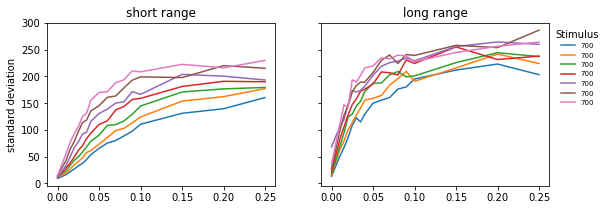

In [220]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(9,3))

for lst, sigma in zip(np.array(stds_s_mean).T, stimulus_range_s):
    ax[0].plot(sigma_lst, lst, label=str(stimulus))
ax[0].set_title('short range')
ax[0].set_ylabel('standard deviation')

for lst, sigma in zip(np.array(stds_l_mean).T, stimulus_range_l):
    ax[1].plot(sigma_lst, lst, label=str(stimulus))
ax[1].set_title('long range')

ax[1].legend(bbox_to_anchor=(1, 1), title='Stimulus', frameon=False,  prop={'size': 7})